# parPE steadystate example model

In [1]:
import amici
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Create sbml model from scratch
!./createSteadystateExampleSBML.py > model_steadystate_scaled.sbml

In [3]:
sbml_file = 'model_steadystate_scaled.sbml'
model_name = 'model_steadystate_scaled'
model_output_dir= 'model_steadystate_scaled'

In [4]:
# Show model info
import libsbml
SBMLreader = libsbml.SBMLReader()
sbml_doc = SBMLreader.readSBML(sbml_file)
sbml_model = sbml_doc.getModel()

print('Species: ', [s.getId() for s in sbml_model.getListOfSpecies()])

print('Parameters: ', [p.getId() for p in sbml_model.getListOfParameters()])

print('\nReactions:')
for reaction in sbml_model.getListOfReactions():
    reactants = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfReactants()])
    products  = ' + '.join(['%s %s'%(int(r.getStoichiometry()) if r.getStoichiometry() > 1 else '', r.getSpecies()) for r in reaction.getListOfProducts()])
    reversible = '<' if reaction.getReversible() else ''
    print('%3s: %10s %1s->%10s\t\t[%s]' % (reaction.getId(), 
                        reactants,
                        reversible,
                        products,
                        libsbml.formulaToL3String(reaction.getKineticLaw().getMath())))


Species:  ['x1', 'x2', 'x3']
Parameters:  ['p1', 'p2', 'p3', 'p4', 'p5', 'k0', 'observable_x1', 'observable_x2', 'observable_x3', 'scaling_x1', 'observable_x1_scaled', 'offset_x2', 'observable_x2_offsetted', 'observable_x1withsigma_sigma', 'observable_x1withsigma']

Reactions:
 r1:       2 x1  ->        x2		[p1 * x1^2]
 r2:   x1 +  x2  ->        x3		[p2 * x1 * x2]
 r3:         x2  ->      2 x1		[p3 * x2]
 r4:         x3  ->  x1 +  x2		[p4 * x3]
 r5:         x3  ->          		[k0 * x3]
 r6:             ->        x1		[p5]


## Generate model code

In [5]:
observables = []
fixed_parameters = ['k0']

def createModule(sbml_model_file, model_name, model_output_dir):
    """Create Python module from SBML model"""
    sbmlImporter = amici.SbmlImporter(sbml_model_file)
    sbml = sbmlImporter.sbml
    global observables
    observables = amici.assignmentRules2observables(sbml, filter=lambda variableId: 
                                                    variableId.startswith('observable_') and not variableId.endswith('_sigma'))
    
    print(observables)
    print(fixed_parameters)

    sbmlImporter.sbml2amici(model_name,
                            output_dir=model_output_dir,
                            observables=observables,
                            constantParameters=fixed_parameters,
                            sigmas={'observable_x1withsigma': 'observable_x1withsigma_sigma'})


createModule(sbml_file, model_name, model_output_dir)



{'observable_x1': 'x1', 'observable_x2': 'x2', 'observable_x3': 'x3', 'observable_x1_scaled': 'scaling_x1 * x1', 'observable_x2_offsetted': 'offset_x2 + x2', 'observable_x1withsigma': 'x1'}
['k0']


## Test simulation

In [6]:
def plotStateTrajectories(rdata):
    for ix in range(rdata['x'].shape[1]):
        plt.plot(rdata['t'], rdata['x'][:, ix], label='$x_%d$' % ix)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$x_i(t)$ (mmol/ml)')
        plt.legend()
        plt.title('State trajectories')
    plt.show()
    
def plotObservableTrajectories(rdata):
    for iy in range(rdata['y'].shape[1]):
        plt.plot(rdata['t'], rdata['y'][:, iy], label='$y_%d$' % iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.legend()
        plt.title('Observables')
    
    plt.show()


[1.  0.5 0.4 2.  0.1 2.  3.  0.2]
{'t': array([1.00000000e-05, 2.06913808e-05, 4.28133240e-05, 8.85866790e-05,
       1.83298071e-04, 3.79269019e-04, 7.84759970e-04, 1.62377674e-03,
       3.35981829e-03, 6.95192796e-03, 1.43844989e-02, 2.97635144e-02,
       6.15848211e-02, 1.27427499e-01, 2.63665090e-01, 5.45559478e-01,
       1.12883789e+00, 2.33572147e+00, 4.83293024e+00, 1.00000000e+01]), 'x': array([[0.1000178 , 0.4000123 , 0.6999792 ],
       [0.10003683, 0.40002545, 0.69995696],
       [0.1000762 , 0.40005266, 0.69991096],
       [0.10015767, 0.40010894, 0.69981577],
       [0.1003262 , 0.40022538, 0.69961885],
       [0.10067479, 0.40046616, 0.6992116 ],
       [0.10139555, 0.4009638 , 0.69836975],
       [0.10288464, 0.40199105, 0.69663131],
       [0.10595616, 0.4041061 , 0.69304903],
       [0.11227026, 0.40843807, 0.6856998 ],
       [0.12515789, 0.41721488, 0.6707597 ],
       [0.15106393, 0.43460508, 0.64095895],
       [0.20141095, 0.46753068, 0.58381562],
       [0.291

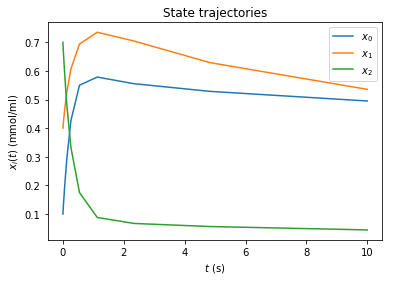

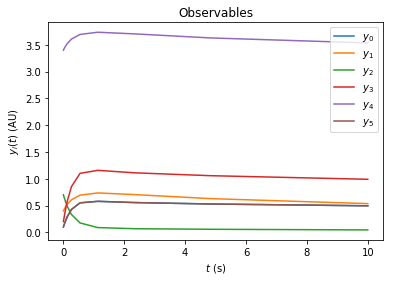

In [7]:
# load model
sys.path.insert(0, model_output_dir)
import model_steadystate_scaled as modelModule

model = modelModule.getModel()
model.setTimepoints(amici.DoubleVector(np.logspace(-5, 1, 20))) 
solver = model.getSolver()
rdata = amici.runAmiciSimulation(model, solver)

default_parameters = np.array(model.getParameters())
print(default_parameters)
print(rdata)

plotStateTrajectories(rdata)
plotObservableTrajectories(rdata)


## Create in silico experimental data for parameter estimation

- Simulate time-course for four different conditions
- Add gaussian noise according to selected sigma parameter
- Mimic 2 experimental batches: odd-numbered condition indices and even-numbered conditions have different offset parameter

In [8]:
expectedLlh = 0.0
sigma_default = 0.1 # parameter are lin
sigma_parameter = 1e8#0.2
offset_batch_1 = 3.0
offset_batch_2 = 4.0
offsetted_observable_idx = 4
sigma_parameter_observable_idx = 5
model_offset_parameter_idx = 6
sigma_parameter_idx = 7
timepoints = np.logspace(-5, 1, 20)

model = modelModule.getModel()
default_parameters = np.array(model.getParameters())
default_parameters[sigma_parameter_idx] = sigma_parameter
true_parameters = default_parameters
true_parameters = np.append(true_parameters, offset_batch_2) # add second offset parameter
print('true_parameters: %s' % true_parameters)

def createData():
    # setup model & solver
    model = modelModule.getModel()
    model.setTimepoints(amici.DoubleVector(timepoints))
    model.setParameters(amici.DoubleVector(default_parameters))
    print('Default parameters: ', default_parameters)
    
    solver = model.getSolver()
    solver.setMaxSteps(10000)

    # generate conditon-vectors
    conditions = [np.array(model.getFixedParameters())]
    conditions.append(conditions[0] * 1.1)
    conditions.append(conditions[0] * 1.2)
    conditions.append(conditions[0] * 1.3)

    conditionDf = createConditionDataframe(fixed_parameters, conditions)
    
    df = pd.DataFrame(data={
        'observable': [],
        'condition': [],
        'conditionRef': [],
        'scalingParameter': [],
        'time': [],
        'measurement': [],
        'sigma': []
    })

    global expectedLlh
    for icondition, condition in enumerate(conditions):      
        print('Condition %d: %s' % (icondition, condition))
        
        # different offset for two "batches"
        batch_id = icondition % 2
        if batch_id == 0:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_1
        else:
            simulationParameters = default_parameters
            simulationParameters[model_offset_parameter_idx] = offset_batch_2
        
        sigmay = np.ones(shape=(model.nt(), model.nytrue)) * sigma_default
        sigmay[:, sigma_parameter_observable_idx] = np.nan # observable with sigma parameter
        
        # simulate condition
        rdata = getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay)
        
        print('\tllh: ', rdata['llh'])
        print('\tsllh', rdata['sllh'])

        expectedLlh += rdata['llh']
        
        conditionName = 'condition-%d' % icondition
        
        # Append data
        for iy, observableName in enumerate(observables.keys()):
            scalingParameter = [''] 
            sigma = sigmay[:, iy]
            
            if observableName == 'observable_x1_scaled':
                #scalingParameter = ['scaling_x1_%s' % conditionName]
                scalingParameter = ['scaling_x1_common']
            elif observableName == 'observable_x2_offsetted':
                #scalingParameter = ['offset_x2_%s' % conditionName]
                #scalingParameter = ['offset_x2_common']
                scalingParameter = ['offset_x2_batch-%d' % batch_id]
            elif observableName == 'observable_x1withsigma':
                #scalingParameter = ['observable_x1withsigma_sigma_%s' % conditionName]
                scalingParameter = ['observable_x1withsigma_sigma_common']
            
            df = df.append(pd.DataFrame(
            {'observable'      : [observableName] * model.nt(),
             'condition'       : [conditionName]  * model.nt(),
             'conditionRef'    : ['']  * model.nt(),
             'scalingParameter': scalingParameter * model.nt(),
             'time'            : np.array(model.getTimepoints()),
             'measurement'     : rdata['y'][:, iy],
             'sigma'           : sigma
             }), ignore_index=True)
    print('Expected llh: ', expectedLlh)
            
    return df, conditionDf


def createConditionDataframe(fixed_parameters, conditions):
    """Create dataframe with fixed-parameters for each condition to simulate"""
    conditionDf = pd.DataFrame(index = fixed_parameters)
    conditionDf['ID'] = conditionDf.index
    for icondition, condition in enumerate(conditions):
        conditionDf['condition-%d' % icondition] = condition
    
    return conditionDf


def getReturnDataForCondition(model, solver, condition, simulationParameters, sigmay):
    model.setParameters(amici.DoubleVector(simulationParameters))
    
    # simulate without measurements
    edata = amici.ExpData(model.get())
    edata.fixedParameters = amici.DoubleVector(condition)
    edata.my = amici.DoubleVector(np.full(shape=model.nt() * model.nytrue, fill_value=np.nan))
    rdata = amici.runAmiciSimulation(model, solver, edata)        
    # fixedParametersPreequilibration = 

    # confirm gradient is 0 for real measurements and save expected llh
    measurement = rdata['y']
    #measurement = np.random.normal(loc=rdata['y'], scale=np.sqrt(sigmay))
    #print((measurement-rdata['y'])/rdata['y'])
    #measurement[:, sigma_parameter_observable_idx] = np.random.normal(
    #    loc=rdata['y'][:, sigma_parameter_observable_idx], 
    #    scale=np.sqrt(simulationParameters[sigma_parameter_idx]))

    edata.my = amici.DoubleVector(measurement.flatten())
    edata.sigmay = amici.DoubleVector(sigmay.flatten())
    solver.setSensitivityMethod(amici.AMICI_SENSI_FSA)
    solver.setSensitivityOrder(amici.AMICI_SENSI_ORDER_FIRST)
    model.requireSensitivitiesForAllParameters()
    rdata = amici.runAmiciSimulation(model, solver, edata)
    
    return rdata

df, conditionDf = createData()

true_parameters: [1.e+00 5.e-01 4.e-01 2.e+00 1.e-01 2.e+00 3.e+00 1.e+08 4.e+00]
Default parameters:  [1.e+00 5.e-01 4.e-01 2.e+00 1.e-01 2.e+00 3.e+00 1.e+08]
Condition 0: [1.]
	llh:  -248.42772956420313
	sllh [-1.19681450e-06 -1.30721325e-06  3.98056903e-06  1.46667403e-06
  5.66724216e-06  2.40838267e-06  3.97264106e-06 -2.00000000e-07]
Condition 1: [1.1]
	llh:  -248.42772956420293
	sllh [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-07]
Condition 2: [1.2]
	llh:  -248.42772956420293
	sllh [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-07]
Condition 3: [1.3]
	llh:  -248.42772956420293
	sllh [ 0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00  0.e+00 -2.e-07]
Expected llh:  -993.710918256812


In [9]:
df

,condition,conditionRef,measurement,observable,scalingParameter,sigma,time
0,condition-0,,0.100018,observable_x1,,0.1,0.000010
1,condition-0,,0.100037,observable_x1,,0.1,0.000021
2,condition-0,,0.100076,observable_x1,,0.1,0.000043
3,condition-0,,0.100158,observable_x1,,0.1,0.000089
4,condition-0,,0.100326,observable_x1,,0.1,0.000183
5,condition-0,,0.100675,observable_x1,,0.1,0.000379
6,condition-0,,0.101396,observable_x1,,0.1,0.000785
7,condition-0,,0.102885,observable_x1,,0.1,0.001624
8,condition-0,,0.105956,observable_x1,,0.1,0.003360
9,condition-0,,0.112270,observable_x1,,0.1,0.006952


In [10]:
conditionDf

,ID,condition-0,condition-1,condition-2,condition-3
k0,k0,1.0,1.1,1.2,1.3


In [11]:
# write data frames to file
measurement_file = 'example_data.tsv'
fixed_parameter_file = 'example_data_fixed.tsv'
hdf5File = 'example_data.h5'

df.to_csv(measurement_file, sep='\t', index=False)
conditionDf.to_csv(fixed_parameter_file, sep='\t', index=False)

# convert to HDF5
import subprocess
out = subprocess.run(['%s/generateHDF5DataFileFromText.py' % os.path.join(os.getcwd(), '..', '..', '..', 'misc'),
    hdf5File,
    sbml_file,
    model_output_dir,
    measurement_file,
    fixed_parameter_file], stdout=subprocess.PIPE, stderr=subprocess.STDOUT)
print(out.stdout.decode("utf-8"))
assert out.returncode==0


Cost shape (480, 7)
Changing t = Inf to t = 1e8.
Num conditions:  4
Num timepoints:  20 [1e-05, 2.0691380811147897e-05, 4.281332398719396e-05, 8.858667904100833e-05, 0.0001832980710832436, 0.000379269019073225, 0.0007847599703514606, 0.001623776739188721, 0.003359818286283781, 0.006951927961775605, 0.014384498882876632, 0.029763514416313162, 0.061584821106602614, 0.1274274985703132, 0.26366508987303555, 0.5455594781168515, 1.1288378916846884, 2.3357214690901213, 4.832930238571752, 10.0]
Fixed parameters orginal:  (1, 4)
Fixed parameters usable:  (1, 4)
Generate parameter list...
Number of simulation parameters: 8
Number of optimization parameters: 9
Generating fixed parameters matrix...
Number of fixed parameters: 1
Generating measurement matrix...
Number of observables: 6
Handling scaling parameters...
Ensure that scaling_x1_common is selected correctly as proportionality factor for hierarchical optimization ().
Number of proportionality factors for hierarchical optimization: 1
Ensure

In [12]:
# write true parameters as first starting point, an perturbed additional points
# two times the same point to check for reproducibility
import h5py
with h5py.File(hdf5File, 'r+') as f:
    for i in range(10):
        parameters = np.log10(true_parameters)
        #parameters = parameters + np.random.normal(0.0, 0.2 + i * 0.1, true_parameters.shape)
        #parameters = np.random.uniform(-3, 5, true_parameters.shape)
        
        #print(parameters)
        f['/optimizationOptions/randomStarts'][:,2*i]   = parameters
        f['/optimizationOptions/randomStarts'][:,2*i+1] = parameters


In [13]:
# enable derivate checker
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test first-order
#!../../../misc/optimizationOptions.py example_data.h5 -s ipopt/derivative_test_print_all yes

!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 0
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            0
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

## Gradient check

In [14]:
for i in range(3):
    !PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deleteme/ example_data.h5


[2018-06-19 23:37:23] [ERR] [-1/]     0 g: -3.82304e+09  fd_c: -2.78579e+09  Δ/fd_c: 3.723363e-01  f:  2.46271e+09
[2018-06-19 23:37:23] [ERR] [-1/]     1 g:      -783992  fd_c:  9.44462e+08  Δ/fd_c: -1.000830e+00  f:  2.46271e+09
[2018-06-19 23:37:23] [ERR] [-1/]     2 g:       978119  fd_c:  1.33272e+09  Δ/fd_c: -9.992661e-01  f:  2.46271e+09
[2018-06-19 23:37:23] [ERR] [-1/]     3 g:      7.86755  fd_c:  5.74932e+08  Δ/fd_c: -1.000000e+00  f:  2.46271e+09
[2018-06-19 23:37:23] [ERR] [-1/]     4 g:  6.86305e+09  fd_c:  5.50096e+09  Δ/fd_c: 2.476091e-01  f:  2.46271e+09
[2018-06-19 23:37:23] [INF] [-1/]     5 g:   1.0343e+10  fd_c:   1.0343e+10  Δ/fd_c: -6.381836e-09  f:  2.46271e+09
[2018-06-19 23:37:23] [INF] [-1/]     6 g:  6.72823e+08  fd_c:  6.72824e+08  Δ/fd_c: -4.045038e-09  f:  2.46271e+09
[2018-06-19 23:37:23] [ERR] [-1/]     7 g:      176.965  fd_c:      143.051  Δ/fd_c: 2.370727e-01  f:  2.46271e+09
[2018-06-19 23:37:23] [ERR] [-1/]     8 g:     -0.52395  fd_c:            0

## Optimize

In [15]:
!pwd
!(cd ../../../build && exec make -j12)
!../../../build/amici/examples/steadystate/example_steadystate_multi -o deleteme/ example_data.h5


/home/dweindl/src/parPE/amici/examples/steadystate
Scanning dependencies of target model_steadystate_scaled
[  7%] Built target parpecommon
-- Found Git: /usr/bin/git (found version "2.17.1") 
[  8%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_J.cpp.o
[  8%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JB.cpp.o
[  9%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparseB.cpp.o
[ 10%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_scaled_JSparse.cpp.o
-- Building version parPE-v0.1.7-10-g83d5-dirty
[ 10%] Building CXX object amici/examples/steadystate/model_steadystate_scaled/CMakeFiles/model_steadystate_scaled.dir/model_steadystate_

[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.0 (0): -248.428 (0) (0.0193s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.1 (1): -248.428 (0) (0.0123s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.2 (2): -248.428 (0) (0.0127s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.3 (3): -248.428 (0) (0.0147s)
Total number of variables............................:        9
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        9
                     variables with only upper bounds:        0
Total number of equality constraints.................:        0
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.0 (0): -16.7877 (0) (0.0092s)
[2018-06-19 23:37:

   3  2.2356485e+00 0.00e+00 2.51e+03   1.0 2.28e+00    -  2.59e-01 3.12e-02f  6
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.0 (0): 14.0066 (0) (0.0011s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.1 (1): 14.1652 (0) (0.0012s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.2 (2): 14.1915 (0) (0.0012s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.3 (3): 14.3418 (0) (0.0012s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.0 (0): 14.0066 (0) (0.0120s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.1 (1): 14.1652 (0) (0.0090s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.2 (2): 14.1915 (0) (0.0093s)
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.3 (3): 14.3418 (0) (0.0101s)
[2018-06-19 23:37:42] [INF] [-1/] iter: 4 cost: -56.7051 time_iter: 0.0650123s time_optim: 0.436177s
   4 -5.6705148e+01 0.00e+00 3.37e+02  -0.7 2.89e-02    -  1.00e+00 1.00e+00f  1
[2018-06-19 23:37:42] [DBG] [-1/] Result for 0.0.0.0 (0): 28.4515 (0) (0.0011s)
[2018-06-19 23:37

[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): 126.966 (0) (0.0097s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): 128.42 (0) (0.0097s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.3 (3): 129.1 (0) (0.0103s)
[2018-06-19 23:37:43] [INF] [-1/] iter: 9 cost: -510.831 time_iter: 0.0640643s time_optim: 0.814703s
   9 -5.1083086e+02 0.00e+00 1.32e+03  -0.4 4.44e-01    -  1.00e+00 1.00e+00f  1
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.0 (0): 70.0152 (0) (0.0010s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): 132.228 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): 70.2198 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.3 (3): 132.872 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.0 (0): 70.0152 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): 132.228 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): 70.2198 (0) (0.0009s)
[2018-06-19 23:37:43]

[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): 163.457 (0) (0.0117s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): 161.702 (0) (0.0124s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.3 (3): 163.846 (0) (0.0095s)
[2018-06-19 23:37:43] [INF] [-1/] iter: 13 cost: -650.312 time_iter: 0.110281s time_optim: 1.18354s
  13 -6.5031208e+02 0.00e+00 7.77e+02  -1.1 8.99e-01    -  1.00e+00 1.56e-02f  7
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.0 (0): 181.73 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): 181.735 (0) (0.0010s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): 181.793 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.3 (3): 181.8 (0) (0.0013s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.0 (0): 181.73 (0) (0.0091s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): 181.735 (0) (0.0108s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): 181.793 (0) (0.0092s)
[2018-06-19 23:37:43] [

[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.0 (0): 198.149 (0) (0.0105s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): 200.661 (0) (0.0100s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): 198.329 (0) (0.0102s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.3 (3): 200.937 (0) (0.0098s)
[2018-06-19 23:37:43] [INF] [-1/] iter: 18 cost: -798.075 time_iter: 0.106159s time_optim: 1.60054s
  18 -7.9807512e+02 0.00e+00 9.34e+02  -5.9 1.01e+01    -  1.00e+00 4.76e-03f  7
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.0 (0): -2882.1 (0) (0.0013s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): -2806.95 (0) (0.0014s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.2 (2): -2798.54 (0) (0.0013s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.3 (3): -2714.17 (0) (0.0013s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.0 (0): -2882.1 (0) (0.0009s)
[2018-06-19 23:37:43] [DBG] [-1/] Result for 0.0.0.1 (1): -2806.95 (0) (0.0009s)
[2018-06-19 23:

[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): 194.092 (0) (0.0010s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 195.017 (0) (0.0010s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 195.953 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 196.529 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): 223.289 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 222.984 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 222.948 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 222.408 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): 223.289 (0) (0.0096s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 222.984 (0) (0.0095s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 222.948 (0) (0.0095s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 222.408 (0) (0.0102s)
[2018-06-19 23:37:44] [INF] [-1/] iter: 

[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 232.303 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 231.331 (0) (0.0010s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 233.213 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): 228.107 (0) (0.0132s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 232.303 (0) (0.0097s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 231.331 (0) (0.0099s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 233.213 (0) (0.0113s)
[2018-06-19 23:37:44] [INF] [-1/] iter: 27 cost: -924.954 time_iter: 0.114224s time_optim: 2.37357s
  27 -9.2495357e+02 0.00e+00 2.98e+03 -11.0 2.17e+00    -  1.00e+00 1.52e-02f  7
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): -2523.84 (0) (0.0013s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): -2570.21 (0) (0.0009s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): -2676.35 (0) (0.0009s)
[2018-06-19 23:3

[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): 124.335 (0) (0.0010s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 108.245 (0) (0.0013s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 125.963 (0) (0.0012s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 109.776 (0) (0.0013s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): 208.22 (0) (0.0012s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 208.329 (0) (0.0012s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 208.73 (0) (0.0012s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 208.659 (0) (0.0012s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.0 (0): 233.454 (0) (0.0013s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.1 (1): 234.79 (0) (0.0013s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.2 (2): 233.326 (0) (0.0012s)
[2018-06-19 23:37:44] [DBG] [-1/] Result for 0.0.0.3 (3): 234.113 (0) (0.0011s)
[2018-06-19 23:37:44] [DBG] [-1/] Result fo

[2018-06-19 23:37:45] [INF] [-1/] iter: 34 cost: -965.537 time_iter: 0.082849s time_optim: 3.02232s
  34 -9.6553665e+02 0.00e+00 4.35e+02 -11.0 1.02e-01    -  1.00e+00 5.00e-01f  2
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): -2.69975e+08 (0) (0.0011s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): -2.57928e+08 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.2 (2): -2.47149e+08 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.3 (3): -2.37422e+08 (0) (0.0010s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): -2.69975e+08 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): -2.57928e+08 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.2 (2): -2.47149e+08 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.3 (3): -2.37422e+08 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): -531000 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): -

[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): 239.855 (0) (0.0011s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): 237.781 (0) (0.0011s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.2 (2): 239.196 (0) (0.0010s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.3 (3): 235.712 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): 243.313 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): 242.075 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.2 (2): 241.901 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.3 (3): 239.441 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): 243.776 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): 242.884 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.2 (2): 242.004 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.3 (3): 239.977 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result

[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): 248.896 (0) (0.0120s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): 248.66 (0) (0.0125s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.2 (2): 250.568 (0) (0.0105s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.3 (3): 248.082 (0) (0.0114s)
[2018-06-19 23:37:45] [INF] [-1/] iter: 40 cost: -996.206 time_iter: 0.112153s time_optim: 3.64578s
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 -9.9620593e+02 0.00e+00 7.98e+03 -10.5 9.36e+00    -  1.00e+00 2.98e-03f  7
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): -15381.3 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.1 (1): -15533 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.2 (2): -15125.6 (0) (0.0009s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.3 (3): -15365.2 (0) (0.0008s)
[2018-06-19 23:37:45] [DBG] [-1/] Result for 0.0.0.0 (0): -15381.3 (0) (0.0009s)
[2018-06-19 23:3

[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): 246.422 (0) (0.0008s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): 248.48 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): 249.067 (0) (0.0010s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): 248.266 (0) (0.0010s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): 249.63 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): 251.457 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): 252.156 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): 251.607 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): 250.269 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): 251.937 (0) (0.0008s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): 252.654 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): 252.182 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result f

[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): -4979.63 (0) (0.0010s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): -4957.13 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): -4947.86 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): -5024.39 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): 114.322 (0) (0.0008s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): 104.666 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): 109.51 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): 101.223 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): 253.396 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): 248.651 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): 249.439 (0) (0.0008s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): 245.283 (0) (0.0010s)
[2018-06-19 23:37:46] [DBG] [-1/] Res

[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): -20969.9 (0) (0.0009s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): -19863.5 (0) (0.0011s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): -974.187 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): -882.913 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): -956.19 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): -857.895 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): 140.758 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): 146.068 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.2 (2): 128.86 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.3 (3): 136.78 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.0 (0): 259.086 (0) (0.0013s)
[2018-06-19 23:37:46] [DBG] [-1/] Result for 0.0.0.1 (1): 254.506 (0) (0.0012s)
[2018-06-19 23:37:46] [DBG] [-1/] Res

[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): 240.98 (0) (0.0010s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 223.316 (0) (0.0010s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): 237.751 (0) (0.0013s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 260.213 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): 266.918 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 256.062 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): 261.997 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 269.845 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): 271.29 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 264.242 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): 265.594 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 269.845 (0) (0.0104s)
[2018-06-19 23:37:47] [DBG] [-1/] Result f

[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): -315.278 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): -3295.83 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): -277.331 (0) (0.0010s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): -3261.41 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 21.548 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): -976.123 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 42.796 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): -956.435 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 187 (0) (0.0008s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): -103.268 (0) (0.0008s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 192.539 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): -97.8565 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Resu

[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): -30.4898 (0) (0.0008s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 69.6246 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): 155.875 (0) (0.0010s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 84.745 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): 168.27 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 222.47 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): 240.979 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 226.758 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): 243.453 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 264.192 (0) (0.0011s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): 266.288 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 263.715 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result f

[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): 275.108 (0) (0.0109s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): 274.539 (0) (0.0102s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): 271.844 (0) (0.0105s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): 270.691 (0) (0.0113s)
[2018-06-19 23:37:47] [INF] [-1/] iter: 58 cost: -1092.18 time_iter: 0.114016s time_optim: 5.63124s
  58 -1.0921817e+03 0.00e+00 2.03e+03  -6.0 9.32e+00    -  1.00e+00 1.24e-03f  8
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): -225818 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): -233297 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.2 (2): -239165 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.3 (3): -239918 (0) (0.0010s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.0 (0): -225818 (0) (0.0009s)
[2018-06-19 23:37:47] [DBG] [-1/] Result for 0.0.0.1 (1): -233297 (0) (0.0009s)
[2018-06-19 23:37:4

[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 270.808 (0) (0.0010s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 257.52 (0) (0.0011s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 267.94 (0) (0.0010s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 253.69 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 275.742 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 271.044 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 271.811 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 266.501 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 276.903 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 274.241 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 272.621 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 269.497 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result fo

[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 67.6717 (0) (0.0010s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 75.9549 (0) (0.0011s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 61.5173 (0) (0.0010s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 217.293 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 210.35 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 210.899 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 205.856 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 262.161 (0) (0.0008s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 258.606 (0) (0.0008s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 257.438 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 255.155 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 274.295 (0) (0.0009s)
[2018-06-19 23:37:48] [DBG] [-1/] Result 

[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 274.254 (0) (0.0010s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 266.51 (0) (0.0011s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 272.771 (0) (0.0010s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 275.39 (0) (0.0013s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 276.13 (0) (0.0012s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 273.101 (0) (0.0012s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 273.676 (0) (0.0012s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.0 (0): 275.39 (0) (0.0138s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 276.13 (0) (0.0103s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 273.101 (0) (0.0103s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.3 (3): 273.676 (0) (0.0122s)
[2018-06-19 23:37:48] [INF] [-1/] iter: 66 cost: -1098.3 time_iter: 0.117663s time_optim: 6.51573s
  66 -1.0982968e+03 0.00e+

[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.1 (1): 275.766 (0) (0.0105s)
[2018-06-19 23:37:48] [DBG] [-1/] Result for 0.0.0.2 (2): 274.144 (0) (0.0103s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): 273.012 (0) (0.0104s)
[2018-06-19 23:37:49] [INF] [-1/] iter: 68 cost: -1099.57 time_iter: 0.11394s time_optim: 6.74103s
  68 -1.0995701e+03 0.00e+00 3.07e+03  -7.4 4.62e-01    -  1.00e+00 7.81e-03f  8
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): -7.18859e+06 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): -7.34712e+06 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): -7.54485e+06 (0) (0.0008s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): -7.76896e+06 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): -7.18859e+06 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): -7.34712e+06 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): -7.54485e+06

[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): 273.213 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): 273.481 (0) (0.0011s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): 270.855 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): 270.062 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): 277.101 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): 276.82 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): 275.311 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): 274.26 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): 277.685 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): 277.104 (0) (0.0012s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): 276.059 (0) (0.0013s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): 274.835 (0) (0.0013s)
[2018-06-19 23:37:49] [DBG] [-1/] Result f

[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): -1.92174e+07 (0) (0.0008s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): -144816 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): -146410 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): -148686 (0) (0.0008s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): -151500 (0) (0.0008s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): -3126.08 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): -3068.75 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): -3065.37 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): -3087.47 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): 93.5476 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): 103.65 (0) (0.0010s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): 104.483 (0) (0.0009s)
[2018-06-19 23:37:49] [DBG] [-1/

[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): 280.986 (0) (0.0099s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): 280.638 (0) (0.0132s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): 280.847 (0) (0.0105s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): 280.664 (0) (0.0095s)
[2018-06-19 23:37:49] [INF] [-1/] iter: 76 cost: -1123.13 time_iter: 0.104271s time_optim: 7.61976s
  76 -1.1231339e+03 0.00e+00 2.44e+04  -9.6 9.57e-01    -  1.00e+00 6.25e-02f  5
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): -9.80252e+07 (0) (0.0010s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): -9.63919e+07 (0) (0.0010s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.2 (2): -9.49742e+07 (0) (0.0010s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.3 (3): -9.36478e+07 (0) (0.0010s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.0 (0): -9.80252e+07 (0) (0.0011s)
[2018-06-19 23:37:49] [DBG] [-1/] Result for 0.0.0.1 (1): -9.63919e+07 (0)

[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): -266711 (0) (0.0011s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): -272779 (0) (0.0016s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): -266769 (0) (0.0012s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): -272894 (0) (0.0011s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): -35208.6 (0) (0.0008s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): -38567.2 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): -36729.5 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): -40075.2 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): -8528.38 (0) (0.0008s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): -9708.94 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): -9195.21 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): -10437.6 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/

[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): 39.6046 (0) (0.0011s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): 38.6567 (0) (0.0013s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): 32.8008 (0) (0.0013s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): 231.918 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): 233.6 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): 230.819 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): 231.208 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): 271.878 (0) (0.0008s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): 273.63 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): 271.048 (0) (0.0011s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): 272.303 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): 280.706 (0) (0.0010s)
[2018-06-19 23:37:50] [DBG] [-1/] Result fo

[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): 283.77 (0) (0.0104s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): 283.272 (0) (0.0097s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): 283.683 (0) (0.0098s)
[2018-06-19 23:37:50] [INF] [-1/] iter: 83 cost: -1134.09 time_iter: 0.0981349s time_optim: 8.42614s
  83 -1.1340906e+03 0.00e+00 1.74e+04  -5.3 1.20e+01    -  1.00e+00 3.53e-03f  6
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): 118.744 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): 158.251 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): 131.283 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): 169.715 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): 118.744 (0) (0.0013s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): 158.251 (0) (0.0010s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): 131.283 (0) (0.0010s)
[2018-06-19 23:37:5

[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.2 (2): 284.535 (0) (0.0009s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.3 (3): 284.484 (0) (0.0011s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.0 (0): 284.785 (0) (0.0099s)
[2018-06-19 23:37:50] [DBG] [-1/] Result for 0.0.0.1 (1): 284.828 (0) (0.0100s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 284.535 (0) (0.0099s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 284.484 (0) (0.0106s)
[2018-06-19 23:37:51] [INF] [-1/] iter: 86 cost: -1138.63 time_iter: 0.117247s time_optim: 8.7484s
  86 -1.1386315e+03 0.00e+00 5.36e+03  -5.0 1.14e+01    -  1.00e+00 6.33e-04f  9
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): -630347 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): -633572 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): -638018 (0) (0.0013s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): -643378 (0) (0.0013s)
[2018-06-19 23:37:51

[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): -12.1507 (0) (0.0010s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): -140.825 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 225.394 (0) (0.0011s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 202.104 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 224.982 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 201.128 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 270.799 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 270.434 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 270.088 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 269.675 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 280.988 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 284.111 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Resu

[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 263.114 (0) (0.0009s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 271.045 (0) (0.0011s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 279.817 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 281.137 (0) (0.0013s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 280.942 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 282.047 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 284.723 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 284.866 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 285.16 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 285.203 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 285.775 (0) (0.0013s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 285.915 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result 

[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 286.162 (0) (0.0013s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 285.026 (0) (0.0013s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 286.584 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 285.225 (0) (0.0013s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 286.49 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 286.12 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 286.734 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 286.183 (0) (0.0012s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.0 (0): 286.49 (0) (0.0148s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.1 (1): 286.12 (0) (0.0103s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.2 (2): 286.734 (0) (0.0111s)
[2018-06-19 23:37:51] [DBG] [-1/] Result for 0.0.0.3 (3): 286.183 (0) (0.0126s)
[2018-06-19 23:37:51] [INF] [-1/] iter: 93 c

[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): 286.906 (0) (0.0126s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): 286.404 (0) (0.0129s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): 286.821 (0) (0.0101s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): 286.274 (0) (0.0104s)
[2018-06-19 23:37:52] [INF] [-1/] iter: 95 cost: -1146.4 time_iter: 0.138994s time_optim: 9.82221s
  95 -1.1464044e+03 0.00e+00 7.04e+02  -4.5 3.81e+00    -  1.00e+00 7.16e-04f 11
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): -212443 (0) (0.0014s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): -1.55452e+06 (0) (0.0011s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): -212415 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): -1.55445e+06 (0) (0.0012s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): -212443 (0) (0.0009s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): -1.55452e+06 (0) (0.0009s)
[2018

[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): 286.74 (0) (0.0012s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): 286.461 (0) (0.0011s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): 286.78 (0) (0.0135s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): 286.541 (0) (0.0130s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): 286.74 (0) (0.0103s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): 286.461 (0) (0.0104s)
[2018-06-19 23:37:52] [INF] [-1/] iter: 97 cost: -1146.52 time_iter: 0.129998s time_optim: 10.0849s
  97 -1.1465214e+03 0.00e+00 3.49e+03  -4.4 1.80e+00    -  1.00e+00 1.95e-03f 10
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): -2.18901e+06 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): -2.1233e+06 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): -2.06485e+06 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): -2.00287e+06 (0) (0.0010s)
[20

[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): -6.14981e+06 (0) (0.0014s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): -6.41953e+06 (0) (0.0014s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): -6.39427e+06 (0) (0.0011s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): -6.59125e+06 (0) (0.0011s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): -424045 (0) (0.0009s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): -450631 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): -444326 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): -463610 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.0 (0): -36098.5 (0) (0.0009s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.1 (1): -39503.5 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.2 (2): -37476.1 (0) (0.0010s)
[2018-06-19 23:37:52] [DBG] [-1/] Result for 0.0.0.3 (3): -40045.7 (0) (0.0009s)
[2018-06-19 23:3

## Compare results

In [16]:
def compareResults(filename, expectedNllh):
    with h5py.File(filename, 'r') as f:
        final_parameters = f['/multistarts/0/finalParameters'][:]
        exit_status = f['/multistarts/0/exitStatus'][:]
        final_cost = f['/multistarts/0/finalCost'][:]
    final_parameters = np.power(10, final_parameters)

    print("#  __Exp___ __Act___ __Err____")
    for i in range(len(true_parameters)):
        print('%d: %6f %6f %6f' % (i, true_parameters[i], final_parameters[i], final_parameters[i]-true_parameters[i]))
    print('Status: %d' % exit_status)
    print('Cost: %f (expected: %f)' % (final_cost, expectedNllh))

In [17]:
compareResults('deleteme/_rank-0001.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 1.011495 0.011495
1: 0.500000 0.494416 -0.005584
2: 0.400000 0.405189 0.005189
3: 2.000000 1.993576 -0.006424
4: 0.100000 0.098906 -0.001094
5: 2.000000 1.938987 -0.061013
6: 3.000000 2.988669 -0.011331
7: 100000000.000000 0.000232 -99999999.999768
8: 4.000000 3.994503 -0.005497
Status: 1
Cost: -1146.878117 (expected: 993.710918)


In [18]:
!rm sim.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank-0001.h5 / sim.h5 / --at-optimum

Running for start 0


In [19]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


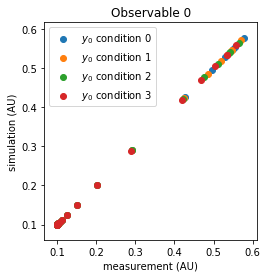

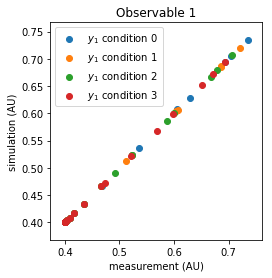

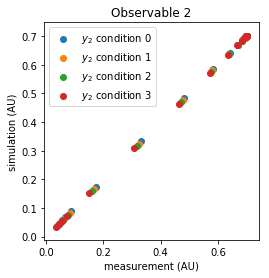

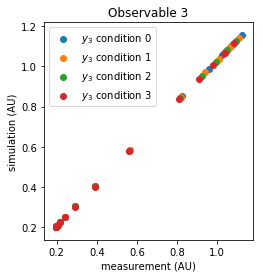

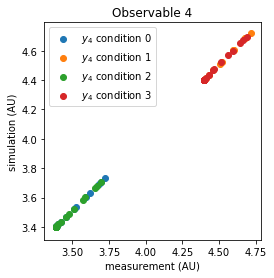

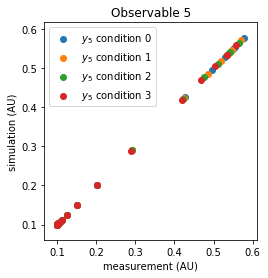

In [20]:
def plotCorrelation(ymes, ysim):
    for iy in range(ysim.shape[2]):
        fig, ax = plt.subplots()
        for icondition in range(ysim.shape[0]):
            ax.scatter(ysim[icondition, :, iy], ymes[icondition, :, iy], label='$y_%d$ condition %d' % (iy, icondition))
        plt.xlabel('measurement (AU)')
        plt.ylabel('simulation (AU)')
        plt.gca().set_aspect('equal', adjustable='box')
        plt.title('Observable %d' % iy)
        plt.legend()
        plt.show()
        
plotCorrelation(ymes, ysim)

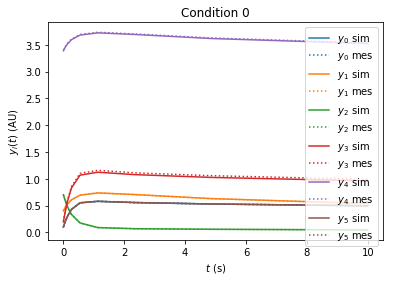

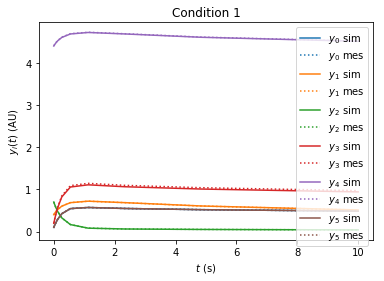

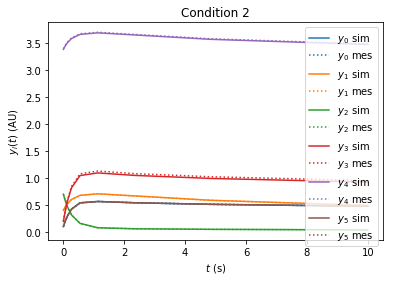

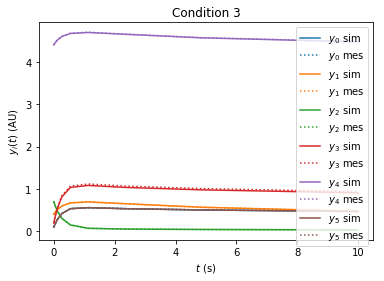

In [21]:
def plotTrajectoryFit(ymes, ysim, timepoints):
    for icondition in range(ysim.shape[0]):
        fig, ax = plt.subplots()
        for iy in range(ysim.shape[2]):
            ax.plot(timepoints, ysim[icondition, :, iy], label='$y_%d$ sim' % (iy), c='C%d'%iy)
            ax.plot(timepoints, ymes[icondition, :, iy], label='$y_%d$ mes' % (iy), linestyle='dotted', c='C%d'%iy)
        plt.xlabel('$t$ (s)')
        plt.ylabel('$y_i(t)$ (AU)')
        plt.title('Condition %d' %icondition)
        plt.legend()
        plt.show()

plotTrajectoryFit(ymes, ysim, timepoints)

## Hierarchical optimization

In [22]:
!../../../misc/optimizationOptions.py example_data.h5 -s hierarchicalOptimization 1
!../../../misc/optimizationOptions.py example_data.h5


                               optimizer            0
                       retryOptimization            1
                               numStarts            1
                hierarchicalOptimization            1
                ceres/max_num_iterations          100
                         fmincon/MaxIter          100
                            fmincon/TolX        1e-08
                          fmincon/TolFun            0
                     fmincon/MaxFunEvals   10000000.0
                       fmincon/algorithm b'interior-point'
                         fmincon/GradObj        b'on'
                         fmincon/display      b'iter'
                          ipopt/max_iter          100
             ipopt/hessian_approximation b'limited-memory'
        ipopt/limited_memory_update_type      b'bfgs'
                               ipopt/tol        1e-09
                   ipopt/acceptable_iter            1
                    ipopt/acceptable_tol        1e+20
         ipopt/acc

In [23]:
# gradient check 
!PARPE_NO_DEBUG=1 ../../../build/amici/examples/steadystate/example_steadystate_multi -t gradient_check -o deleteme/ example_data.h5


HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-19 23:37:56] [WRN] [-1/]     0 g:     -332.761  fd_c:     -348.754  Δ/fd_c: -4.585703e-02  f:      32092.3
[2018-06-19 23:37:56] [WRN] [-1/]     1 g:      595.132  fd_c:      610.637  Δ/fd_c: -2.539159e-02  f:      32092.3
[2018-06-19 23:37:56] [WRN] [-1/]     2 g:      639.081  fd_c:      625.266  Δ/fd_c: 2.209482e-02  f:      32092.3
[2018-06-19 23:37:56] [ERR] [-1/]     3 g:     -5.76354  fd_c:       20.522  Δ/fd_c: -1.280846e+00  f:      32092.3
[2018-06-19 23:37:56] [WRN] [-1/]     4 g:      326.709  fd_c:      304.693  Δ/fd_c: 7.225803e-02  f:      32092.3
[2018-06-19 23:37:56] [INF] [-1/] Walltime on master: 0.339586s, CPU time of all processes: 0.559519s


In [24]:
# optimization
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deleteme/ example_data.h5


[2018-06-19 23:37:57] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-06-19 23:37:57] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-06-19 23:37:57] [DBG] [1/dweindl] Seeding RNG with 1529444277
[2018-06-19 23:37:57] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-06-19 23:37:57] [DBG] [2/dweindl] Seeding RNG with 1529444277
[2018-06-19 23:37:57] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-06-19 23:37:57] [DBG] [3/dweindl] Seeding RNG with 1529444277
[2018-06-19 23:37:57] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-06-19 23:37:57] [DBG] [0/dweindl] Seeding RNG with 1529444277
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-19 23:37:57] [DBG] [2/dweindl] Writing results to deleteme/_rank00002.h5.
[2018-06-19 23:37:57] [DBG] [0/dweindl] Writing results to deleteme/_rank00000.h5.
HierachicalO

[2018-06-19 23:37:57] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -3189.62 (0) (0.0991s)
[2018-06-19 23:37:57] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -7305.95 (0) (0.0803s)
[2018-06-19 23:37:58] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -3174.17 (0) (0.0829s)
[2018-06-19 23:37:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -7277.65 (0) (0.0482s)
[2018-06-19 23:37:58] [INF] [0/dweindl] iter: 2 cost: 20947.4 time_iter: 0.36498s time_optim: 0.775023s
   2  2.0947397e+04 0.00e+00 1.75e+01  -4.6 3.87e-01    -  9.23e-01 1.00e+00f  1
[2018-06-19 23:37:58] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -7023.27 (0) (0.0020s)
[2018-06-19 23:37:58] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12975.7 (0) (0.0033s)
[2018-06-19 23:37:58] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6989.96 (0) (0.0022s)
[2018-06-19 23:37:58] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12929.5 (0) (0.0021s)
[2018-06-19 23:37:58] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -7023.27 (0) (0.0020s)
[2018-06-19 23:37:58] [DBG] [0/d

[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2848.21 (0) (0.3987s)
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6491.79 (0) (0.4795s)
[2018-06-19 23:38:07] [INF] [0/dweindl] iter: 8 cost: 18714.9 time_iter: 1.65095s time_optim: 10.2763s
   8  1.8714910e+04 0.00e+00 9.56e+00  -3.7 2.78e-01    -  1.00e+00 6.22e-02f  1
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6609.55 (0) (0.0019s)
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12329.6 (0) (0.0020s)
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6576.86 (0) (0.0019s)
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12283.9 (0) (0.0020s)
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6609.55 (0) (0.0020s)
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12329.6 (0) (0.0019s)
[2018-06-19 23:38:07] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6576.86 (0) (0.0019s)
[2018-06-19 23:38:07] [DBG] [0/dw

[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6504.2 (0) (0.5674s)
[2018-06-19 23:38:19] [INF] [0/dweindl] iter: 14 cost: 18666 time_iter: 1.93345s time_optim: 21.84s
  14  1.8666031e+04 0.00e+00 2.97e-03 -11.0 4.59e-05    -  1.00e+00 1.00e+00f  1
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.04 (0) (0.0020s)
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.7 (0) (0.0020s)
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0020s)
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0021s)
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.04 (0) (0.0020s)
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.7 (0) (0.0020s)
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0021s)
[2018-06-19 23:38:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0022s)
[2018-06-19 23:38:19] [DBG] [0/dweind

[2018-06-19 23:38:27] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.2 (0) (0.0038s)
[2018-06-19 23:38:27] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12294.3 (0) (0.0071s)
[2018-06-19 23:38:27] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.77 (0) (0.0028s)
[2018-06-19 23:38:27] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.8 (0) (0.0028s)
[2018-06-19 23:38:28] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -2821.23 (0) (0.5120s)
[2018-06-19 23:38:28] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -6529.4 (0) (0.5733s)
[2018-06-19 23:38:29] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2811 (0) (0.7287s)
[2018-06-19 23:38:30] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6504.36 (0) (0.7274s)
[2018-06-19 23:38:30] [INF] [0/dweindl] iter: 19 cost: 18666 time_iter: 2.63222s time_optim: 33.0886s
  19  1.8665996e+04 0.00e+00 6.60e-02 -11.0 5.10e-01    -  1.00e+00 1.00e+00f  1
[2018-06-19 23:38:30] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6596.97 (0) (0.0024s)
[2018-06-19 23:38:30] [DBG] [0/dweindl]

[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12295.2 (0) (0.0070s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6566.06 (0) (0.0024s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12250.6 (0) (0.0026s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.29 (0) (0.0025s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12294.5 (0) (0.0025s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.84 (0) (0.0026s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.9 (0) (0.0025s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.16 (0) (0.0025s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12294.1 (0) (0.0025s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.73 (0) (0.0024s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.5 (0) (0.0025s)
[2018-06-19 23:38:37] [DBG] [0/dweindl] Res

[2018-06-19 23:38:47] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0131s)
[2018-06-19 23:38:48] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -2821.39 (0) (0.7933s)
[2018-06-19 23:38:48] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -6529.24 (0) (0.7341s)
[2018-06-19 23:38:49] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2811.16 (0) (0.6992s)
[2018-06-19 23:38:50] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6504.2 (0) (0.6766s)
[2018-06-19 23:38:50] [INF] [0/dweindl] iter: 27 cost: 18666 time_iter: 3.01251s time_optim: 52.8995s
  27  1.8665983e+04 0.00e+00 9.79e-03 -11.0 2.89e-02    -  1.00e+00 1.00e+00f  1
[2018-06-19 23:38:50] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6596.73 (0) (0.0041s)
[2018-06-19 23:38:50] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12292.7 (0) (0.0040s)
[2018-06-19 23:38:50] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.34 (0) (0.0043s)
[2018-06-19 23:38:50] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12248.2 (0) (0.0043s)
[2018-06-19 23:38:50] [DBG] [0/dwei

[2018-06-19 23:38:59] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0037s)
[2018-06-19 23:38:59] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0036s)
[2018-06-19 23:38:59] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0036s)
[2018-06-19 23:38:59] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0036s)
[2018-06-19 23:39:00] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0038s)
[2018-06-19 23:39:00] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0034s)
[2018-06-19 23:39:00] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0040s)
[2018-06-19 23:39:00] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0036s)
[2018-06-19 23:39:00] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -2821.41 (0) (0.4728s)
[2018-06-19 23:39:01] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -6529.21 (0) (0.5096s)
[2018-06-19 23:39:01] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2811.18 (0) (0.5551s)
[2018-06-19 23:39:02] [DBG] [0/dweindl] Res

[2018-06-19 23:39:10] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -2821.41 (0) (0.3980s)
[2018-06-19 23:39:10] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -6529.21 (0) (0.4962s)
[2018-06-19 23:39:11] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2811.19 (0) (0.5188s)
[2018-06-19 23:39:11] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6504.17 (0) (0.6459s)
[2018-06-19 23:39:12] [INF] [0/dweindl] iter: 37 cost: 18666 time_iter: 2.11883s time_optim: 74.7205s
  37  1.8665983e+04 0.00e+00 9.36e-05 -11.0 1.90e-05    -  1.00e+00 1.00e+00f  1
[2018-06-19 23:39:12] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0027s)
[2018-06-19 23:39:12] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0027s)
[2018-06-19 23:39:12] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0027s)
[2018-06-19 23:39:12] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0027s)
[2018-06-19 23:39:12] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0107s)
[2018-06-19 23:39:12] [DBG] [0/dwe

[2018-06-19 23:39:15] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -2821.41 (0) (0.4332s)
[2018-06-19 23:39:15] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -6529.21 (0) (0.4059s)
[2018-06-19 23:39:16] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2811.19 (0) (0.4016s)
[2018-06-19 23:39:16] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6504.17 (0) (0.4748s)
[2018-06-19 23:39:16] [INF] [0/dweindl] iter: 39 cost: 18666 time_iter: 2.13233s time_optim: 79.2533s
  39  1.8665983e+04 0.00e+00 7.78e-05 -11.0 1.38e-06    -  1.00e+00 1.22e-04f 14
[2018-06-19 23:39:16] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0029s)
[2018-06-19 23:39:16] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0026s)
[2018-06-19 23:39:16] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0027s)
[2018-06-19 23:39:16] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0027s)
[2018-06-19 23:39:16] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0029s)
[2018-06-19 23:39:16] [DBG] [0/dwe

[2018-06-19 23:39:18] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0026s)
[2018-06-19 23:39:18] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0028s)
[2018-06-19 23:39:18] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0028s)
[2018-06-19 23:39:18] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0037s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0036s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0028s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0041s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0029s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0029s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0030s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0051s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Res

[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0043s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0028s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0026s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6565.64 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12249.3 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -6597.06 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -12293.8 (0) (0.0027s)
[2018-06-19 23:39:19] [DBG] [0/dweindl] Res

In [25]:
compareResults('deleteme/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 1000.000069 999.000069
1: 0.500000 0.000010 -0.499990
2: 0.400000 49.904304 49.504304
3: 2.000000 1000.000069 998.000069
4: 0.100000 0.151402 0.051402
5: 2.000000 1.842532 -0.157468
6: 3.000000 1.000000 -2.000000
7: 100000000.000000 1.000000 -99999999.000000
8: 4.000000 1.000000 -3.000000
Status: 4
Cost: 18665.982588 (expected: 993.710918)


In [26]:
!rm simh.h5
!../../../build/amici/examples/steadystate/example_steadystate_multi_simulator deleteme/_rank00000.h5 / simh.h5 / --at-optimum

Running for start 0


In [27]:
with h5py.File('sim.h5', 'r') as f:
    ysim = f['/multistarts/0/ySim'][:]
    ymes = f['/multistarts/0/yMes'][:]
print(ysim.shape)
print(ymes.shape)

(4, 20, 6)
(4, 20, 6)


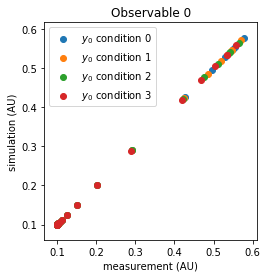

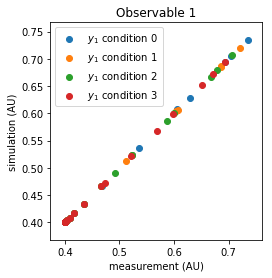

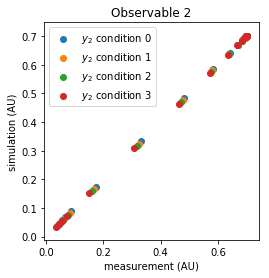

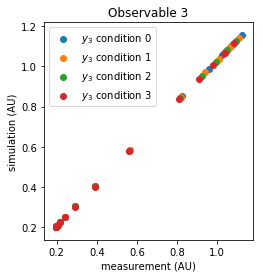

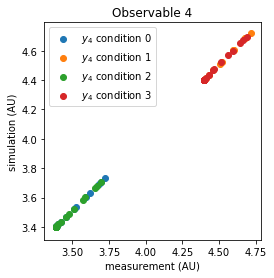

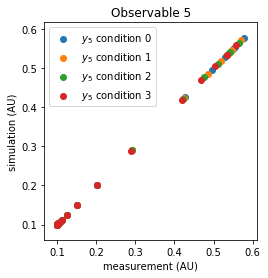

In [28]:
plotCorrelation(ymes, ysim)

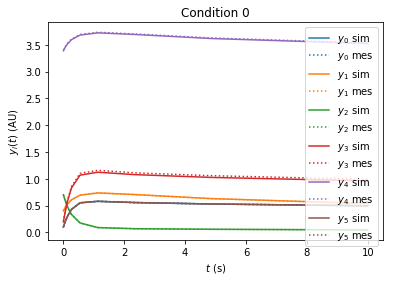

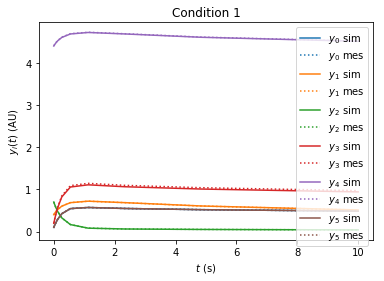

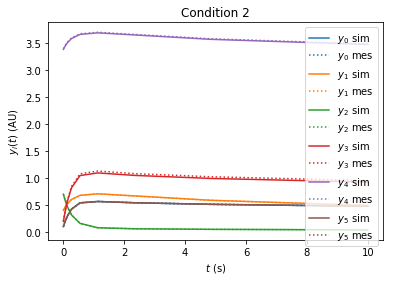

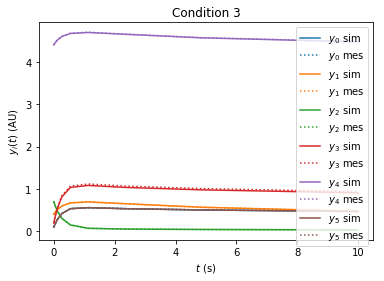

In [29]:
plotTrajectoryFit(ymes, ysim, timepoints)

## Ceres

In [30]:
!../../../misc/optimizationOptions.py example_data.h5 -s optimizer 1
!mpiexec -n 4 ../../../build/amici/examples/steadystate/example_steadystate_multi  -o deleteme/ example_data.h5


[2018-06-19 23:39:24] [INF] [0/dweindl] Running with 4 MPI processes.
[2018-06-19 23:39:24] [DBG] [2/dweindl] Rank 2/4 running on dweindl.
[2018-06-19 23:39:24] [DBG] [2/dweindl] Seeding RNG with 1529444364
[2018-06-19 23:39:24] [DBG] [1/dweindl] Rank 1/4 running on dweindl.
[2018-06-19 23:39:24] [DBG] [1/dweindl] Seeding RNG with 1529444364
[2018-06-19 23:39:24] [DBG] [0/dweindl] Rank 0/4 running on dweindl.
[2018-06-19 23:39:24] [DBG] [0/dweindl] Seeding RNG with 1529444364
[2018-06-19 23:39:24] [DBG] [3/dweindl] Rank 3/4 running on dweindl.
[2018-06-19 23:39:24] [DBG] [3/dweindl] Seeding RNG with 1529444364
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-19 23:39:24] [DBG] [2/dweindl] Writing results to deleteme/_rank00002.h5.
HierachicalOptimizationWrapper parameters: 9 total, 5 numerical, 1 proportionality, 2 offset, 1 sigma
[2018-06-19 23:39:24] [DBG] [1/dweindl] Writing results to deleteme/_rank00001.h5.
HierachicalO

[2018-06-19 23:39:30] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6980.79 (0) (0.4296s)
line_search.cc:584 Line search failed: Wolfe bracketing phase shrank bracket width: 0, to < tolerance: 1e-09, with descent_direction_max_norm: 4072.89, and failed to find a point satisfying the strong Wolfe conditions or a bracketing containing such a point. Accepting point found satisfying Armijo condition only, to allow continuation.
callbacks.cc:105    4: f: 1.999548e+04 d: 3.35e+02 g: 9.03e+02 h: 4.98e-01 s: 9.39e-05 e: 12 it: 3.49e+00 tt: 5.95e+00
[2018-06-19 23:39:30] [INF] [0/dweindl] iter: 4 cost: 19995.5 time_iter: 3.49339s time_optim: 5.95092s
[2018-06-19 23:39:30] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -7028.13 (0) (0.0023s)
[2018-06-19 23:39:30] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -13018.3 (0) (0.0023s)
[2018-06-19 23:39:30] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6997.63 (0) (0.0023s)
[2018-06-19 23:39:30] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12976 (0) (0.0047s)
[2018-0

[2018-06-19 23:39:44] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -3009.45 (0) (0.3851s)
[2018-06-19 23:39:45] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -7006.85 (0) (0.3938s)
[2018-06-19 23:39:45] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2993.8 (0) (0.3790s)
[2018-06-19 23:39:45] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -6978.05 (0) (0.4486s)
[2018-06-19 23:39:45] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -7027.37 (0) (0.0044s)
[2018-06-19 23:39:45] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -13017 (0) (0.0059s)
[2018-06-19 23:39:45] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -6996.86 (0) (0.0022s)
[2018-06-19 23:39:45] [DBG] [0/dweindl] Result for 0.0.0.3 (3): -12974.7 (0) (0.0021s)
[2018-06-19 23:39:46] [DBG] [0/dweindl] Result for 0.0.0.0 (0): -3009.45 (0) (0.3871s)
[2018-06-19 23:39:46] [DBG] [0/dweindl] Result for 0.0.0.1 (1): -7006.85 (0) (0.3766s)
[2018-06-19 23:39:47] [DBG] [0/dweindl] Result for 0.0.0.2 (2): -2993.8 (0) (0.3561s)
[2018-06-19 23:39:47] [DBG] [0/dweindl] Result 

In [31]:
compareResults('deleteme/_rank00000.h5', -expectedLlh)

#  __Exp___ __Act___ __Err____
0: 1.000000 3.335362 2.335362
1: 0.500000 2.820181 2.320181
2: 0.400000 0.847037 0.447037
3: 2.000000 999.998068 997.998068
4: 0.100000 0.127349 0.027349
5: 2.000000 0.877665 -1.122335
6: 3.000000 1.000000 -2.000000
7: 100000000.000000 1.000000 -99999999.000000
8: 4.000000 1.000000 -3.000000
Status: 0
Cost: 19988.151439 (expected: 993.710918)


# TODO

## preeequilibration
## different optimizers
## improve timing